In [1]:
import tensorflow as tf
import math
import numpy as np
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE
img_w = 192
img_h = 192

c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\alex0\anaconda3\envs\tflocal\lib\site-packages\tensorflow\

In [3]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_w, img_h])
    image /= 255
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [4]:
with open('data/img_celeba/list_eval_partition.txt') as f:
            filenames = f.read().splitlines()
for i in range(len(filenames)):
    filenames[i] = "data/img_celeba/" + filenames[i].split(" ")[0]
print(filenames[0])

data/img_celeba/000001.jpg


In [5]:
path_ds = tf.data.Dataset.from_tensor_slices(filenames)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [6]:
print(image_ds)

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>


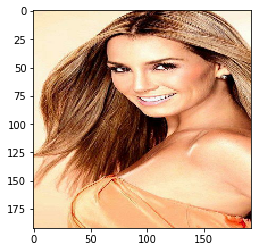

In [7]:
sess = tf.Session()
output = image_ds.make_one_shot_iterator().get_next()
plt.imshow(sess.run(output))
plt.show()

In [8]:
delta_h = 64
delta_w = 64

In [9]:
height = tf.constant(64)
width = tf.constant(64)
vertical_margin = 6
horizontal_margin = 6
lim_top = img_h - img_h // vertical_margin - height  
lim_left = img_w - img_w // horizontal_margin - width
t = tf.random_uniform([], minval=vertical_margin, maxval=lim_top, dtype=tf.int32)
l = tf.random_uniform([], minval=horizontal_margin, maxval=lim_left, dtype=tf.int32)

bbox = (t, l, height, width)
bbox = sess.run(bbox)
print(bbox)


(31, 90, 64, 64)


6


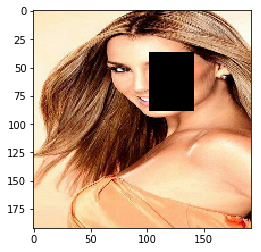

In [10]:
mask = np.ones((img_h, img_w, 3), np.float32)
h = np.random.randint(delta_h//2+1)
w = np.random.randint(delta_w//2+1)
print(h)
mask[bbox[0]+h:bbox[0]+bbox[2]-h,
     bbox[1]+w:bbox[1]+bbox[3]-w, :] = 0.
#print(mask)
masked = image_ds.map(lambda x: tf.multiply(x, mask))
output = masked.make_one_shot_iterator().get_next()
plt.imshow(sess.run(output))
plt.show()

Instructions for updating:
Colocations handled automatically by placer.


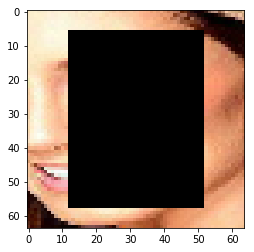

In [11]:
cropped = masked.map(lambda x: tf.image.crop_to_bounding_box(x, bbox[0], bbox[1], bbox[2], bbox[3]))

output = cropped.make_one_shot_iterator().get_next()
plt.imshow(sess.run(output))
plt.show()

In [13]:
def gen_conv(x, cnum, ksize, stride=1, rate=1, name='conv',
             padding='SAME', activation=tf.nn.relu):

    x = tf.layers.conv2d(
        x, cnum, ksize, stride, dilation_rate=rate,
        activation=activation, padding='SAME', name=name)
    return x

In [14]:
def gen_deconv(x, cnum, name='upsample'):
    x = resize(x, func=tf.image.resize_nearest_neighbor)
    x = gen_conv(
        x, cnum, 3, 1, name=name+'_conv', padding='SAME',
        training=training)
    return x

In [15]:
def dis_conv(x, cnum, ksize=5, stride=2, name='conv'):
    x = tf.layers.conv2d(x, cnum, ksize, stride, 'SAME', name=name)
    x = tf.nn.leaky_relu(x)
    return x

In [17]:
def resize_mask_like(mask, x):
    mask_resize = resize(
        mask, to_shape=x.get_shape().as_list()[1:3],
        func=tf.image.resize_nearest_neighbor)
    return mask_resize

In [19]:
def contextual_attention(f, b, mask=None, ksize=3, stride=1, rate=1,
                         fuse_k=3, softmax_scale=10., training=True, fuse=True):
    """ Contextual attention layer implementation.
    Contextual attention is first introduced in publication:
        Generative Image Inpainting with Contextual Attention, Yu et al.
    Args:
        x: Input feature to match (foreground).
        t: Input feature for match (background).
        mask: Input mask for t, indicating patches not available.
        ksize: Kernel size for contextual attention.
        stride: Stride for extracting patches from t.
        rate: Dilation for matching.
        softmax_scale: Scaled softmax for attention.
        training: Indicating if current graph is training or inference.
    Returns:
        tf.Tensor: output
    """
    # get shapes
    raw_fs = tf.shape(f)
    raw_int_fs = f.get_shape().as_list()
    raw_int_bs = b.get_shape().as_list()
    # extract patches from background with stride and rate
    kernel = 2*rate
    raw_w = tf.extract_image_patches(
        b, [1,kernel,kernel,1], [1,rate*stride,rate*stride,1], [1,1,1,1], padding='SAME')
    raw_w = tf.reshape(raw_w, [raw_int_bs[0], -1, kernel, kernel, raw_int_bs[3]])
    raw_w = tf.transpose(raw_w, [0, 2, 3, 4, 1])  # transpose to b*k*k*c*hw
    # downscaling foreground option: downscaling both foreground and
    # background for matching and use original background for reconstruction.
    f = resize(f, scale=1./rate, func=tf.image.resize_nearest_neighbor)
    b = resize(b, to_shape=[int(raw_int_bs[1]/rate), int(raw_int_bs[2]/rate)], func=tf.image.resize_nearest_neighbor)  # https://github.com/tensorflow/tensorflow/issues/11651
    if mask is not None:
        mask = resize(mask, scale=1./rate, func=tf.image.resize_nearest_neighbor)
    fs = tf.shape(f)
    int_fs = f.get_shape().as_list()
    f_groups = tf.split(f, int_fs[0], axis=0)
    # from t(H*W*C) to w(b*k*k*c*h*w)
    bs = tf.shape(b)
    int_bs = b.get_shape().as_list()
    w = tf.extract_image_patches(
        b, [1,ksize,ksize,1], [1,stride,stride,1], [1,1,1,1], padding='SAME')
    w = tf.reshape(w, [int_fs[0], -1, ksize, ksize, int_fs[3]])
    w = tf.transpose(w, [0, 2, 3, 4, 1])  # transpose to b*k*k*c*hw
    # process mask
    if mask is None:
        mask = tf.zeros([1, bs[1], bs[2], 1])
    m = tf.extract_image_patches(
        mask, [1,ksize,ksize,1], [1,stride,stride,1], [1,1,1,1], padding='SAME')
    m = tf.reshape(m, [1, -1, ksize, ksize, 1])
    m = tf.transpose(m, [0, 2, 3, 4, 1])  # transpose to b*k*k*c*hw
    m = m[0]
    mm = tf.cast(tf.equal(tf.reduce_mean(m, axis=[0,1,2], keep_dims=True), 0.), tf.float32)
    w_groups = tf.split(w, int_bs[0], axis=0)
    raw_w_groups = tf.split(raw_w, int_bs[0], axis=0)
    y = []
    offsets = []
    k = fuse_k
    scale = softmax_scale
    fuse_weight = tf.reshape(tf.eye(k), [k, k, 1, 1])
    for xi, wi, raw_wi in zip(f_groups, w_groups, raw_w_groups):
        # conv for compare
        wi = wi[0]
        wi_normed = wi / tf.maximum(tf.sqrt(tf.reduce_sum(tf.square(wi), axis=[0,1,2])), 1e-4)
        yi = tf.nn.conv2d(xi, wi_normed, strides=[1,1,1,1], padding="SAME")

        # conv implementation for fuse scores to encourage large patches
        if fuse:
            yi = tf.reshape(yi, [1, fs[1]*fs[2], bs[1]*bs[2], 1])
            yi = tf.nn.conv2d(yi, fuse_weight, strides=[1,1,1,1], padding='SAME')
            yi = tf.reshape(yi, [1, fs[1], fs[2], bs[1], bs[2]])
            yi = tf.transpose(yi, [0, 2, 1, 4, 3])
            yi = tf.reshape(yi, [1, fs[1]*fs[2], bs[1]*bs[2], 1])
            yi = tf.nn.conv2d(yi, fuse_weight, strides=[1,1,1,1], padding='SAME')
            yi = tf.reshape(yi, [1, fs[2], fs[1], bs[2], bs[1]])
            yi = tf.transpose(yi, [0, 2, 1, 4, 3])
        yi = tf.reshape(yi, [1, fs[1], fs[2], bs[1]*bs[2]])

        # softmax to match
        yi *=  mm  # mask
        yi = tf.nn.softmax(yi*scale, 3)
        yi *=  mm  # mask

        offset = tf.argmax(yi, axis=3, output_type=tf.int32)
        offset = tf.stack([offset // fs[2], offset % fs[2]], axis=-1)
        # deconv for patch pasting
        # 3.1 paste center
        wi_center = raw_wi[0]
        yi = tf.nn.conv2d_transpose(yi, wi_center, tf.concat([[1], raw_fs[1:]], axis=0), strides=[1,rate,rate,1]) / 4.
        y.append(yi)
        offsets.append(offset)
    y = tf.concat(y, axis=0)
    y.set_shape(raw_int_fs)
    offsets = tf.concat(offsets, axis=0)
    offsets.set_shape(int_bs[:3] + [2])
    # case1: visualize optical flow: minus current position
    h_add = tf.tile(tf.reshape(tf.range(bs[1]), [1, bs[1], 1, 1]), [bs[0], 1, bs[2], 1])
    w_add = tf.tile(tf.reshape(tf.range(bs[2]), [1, 1, bs[2], 1]), [bs[0], bs[1], 1, 1])
    offsets = offsets - tf.concat([h_add, w_add], axis=3)
    # to flow image
    flow = flow_to_image_tf(offsets)
    # # case2: visualize which pixels are attended
    # flow = highlight_flow_tf(offsets * tf.cast(mask, tf.int32))
    if rate != 1:
        flow = resize(flow, scale=rate, func=tf.image.resize_nearest_neighbor)
    return y, flow

In [20]:
class Inpainter():
    def build_inpainter(self, x, mask):
        xin = x
        offset_flow = None
        ones_x = tf.ones_like(x)[:, :, :, 0:1]
        x = tf.concat([x, ones_x, ones_x*mask], axis=3)
        cnum = 32
        x = gen_conv(x, 2*cnum, 3, 2, name='conv2_downsample')
        x = gen_conv(x, 2*cnum, 3, 1, name='conv3')
        x = gen_conv(x, 4*cnum, 3, 2, name='conv4_downsample')
        x = gen_conv(x, 4*cnum, 3, 1, name='conv5')
        x = gen_conv(x, 4*cnum, 3, 1, name='conv6')
        mask_s = resize_mask_like(mask, x)
        x = gen_conv(x, 4*cnum, 3, rate=2, name='conv7_atrous')
        x = gen_conv(x, 4*cnum, 3, rate=4, name='conv8_atrous')
        x = gen_conv(x, 4*cnum, 3, rate=8, name='conv9_atrous')
        x = gen_conv(x, 4*cnum, 3, rate=16, name='conv10_atrous')
        x = gen_conv(x, 4*cnum, 3, 1, name='conv11')
        x = gen_conv(x, 4*cnum, 3, 1, name='conv12')
        x = gen_deconv(x, 2*cnum, name='conv13_upsample')
        x = gen_conv(x, 2*cnum, 3, 1, name='conv14')
        x = gen_deconv(x, cnum, name='conv15_upsample')
        x = gen_conv(x, cnum//2, 3, 1, name='conv16')
        x = gen_conv(x, 3, 3, 1, activation=None, name='conv17')
        x = tf.clip_by_value(x, -1., 1.)
        x_stage1 = x
        
        x = x*mask + xin*(1.-mask)
        x.set_shape(xin.get_shape().as_list())
        xnow = tf.concat([x, ones_x, ones_x*mask], axis=3)
        x = gen_conv(xnow, cnum, 5, 1, name='xconv1')
        x = gen_conv(x, cnum, 3, 2, name='xconv2_downsample')
        x = gen_conv(x, 2*cnum, 3, 1, name='xconv3')
        x = gen_conv(x, 2*cnum, 3, 2, name='xconv4_downsample')
        x = gen_conv(x, 4*cnum, 3, 1, name='xconv5')
        x = gen_conv(x, 4*cnum, 3, 1, name='xconv6')
        x = gen_conv(x, 4*cnum, 3, rate=2, name='xconv7_atrous')
        x = gen_conv(x, 4*cnum, 3, rate=4, name='xconv8_atrous')
        x = gen_conv(x, 4*cnum, 3, rate=8, name='xconv9_atrous')
        x = gen_conv(x, 4*cnum, 3, rate=16, name='xconv10_atrous')
        x_hallu = x
        # attention branch
        x = gen_conv(xnow, cnum, 5, 1, name='pmconv1')
        x = gen_conv(x, cnum, 3, 2, name='pmconv2_downsample')
        x = gen_conv(x, 2*cnum, 3, 1, name='pmconv3')
        x = gen_conv(x, 4*cnum, 3, 2, name='pmconv4_downsample')
        x = gen_conv(x, 4*cnum, 3, 1, name='pmconv5')
        x = gen_conv(x, 4*cnum, 3, 1, name='pmconv6',
                    activation=tf.nn.relu)
        x, offset_flow = contextual_attention(x, x, mask_s, 3, 1, rate=2)
        x = gen_conv(x, 4*cnum, 3, 1, name='pmconv9')
        x = gen_conv(x, 4*cnum, 3, 1, name='pmconv10')
        pm = x
        x = tf.concat([x_hallu, pm], axis=3)

        x = gen_conv(x, 4*cnum, 3, 1, name='allconv11')
        x = gen_conv(x, 4*cnum, 3, 1, name='allconv12')
        x = gen_deconv(x, 2*cnum, name='allconv13_upsample')
        x = gen_conv(x, 2*cnum, 3, 1, name='allconv14')
        x = gen_deconv(x, cnum, name='allconv15_upsample')
        x = gen_conv(x, cnum//2, 3, 1, name='allconv16')
        x = gen_conv(x, 3, 3, 1, activation=None, name='allconv17')
        x_stage2 = tf.clip_by_value(x, -1., 1.)
        return x_stage1, x_stage2, offset_flow

In [ ]:
def build_graph_with_losses(self, batch_data, config, training=True,
                            summary=False, reuse=False):
    

In [ ]:
with open('data/img_celeba/list_eval_partition.txt') as f:
            filenames = f.read().splitlines()
path_ds = tf.data.Dataset.from_tensor_slices(filenames)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
ds = tf.data.Dataset.zip((path_ds, image_ds))
model = InpainterModel()

In [12]:
sess.close()